In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
from PIL import Image
import glob

2023-11-27 23:04:47.796335: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
from pathlib import Path
data_dir = Path("dataset/training_set/")

Let us see how many images we have

In [21]:
image_count = len(list(data_dir.glob('*/*.png')))
print("total images :",image_count)
categories = [x.parts[2] for x in list(data_dir.glob("*/"))]
for category in categories:
    print(category + "\t:", len(list(data_dir.glob(category + "/*.png"))))

total images : 10341
background	: 1882
three	: 1683
thumbsup	: 1303
up	: 1758
two	: 996
L	: 1102
four	: 1617


### Sample Images

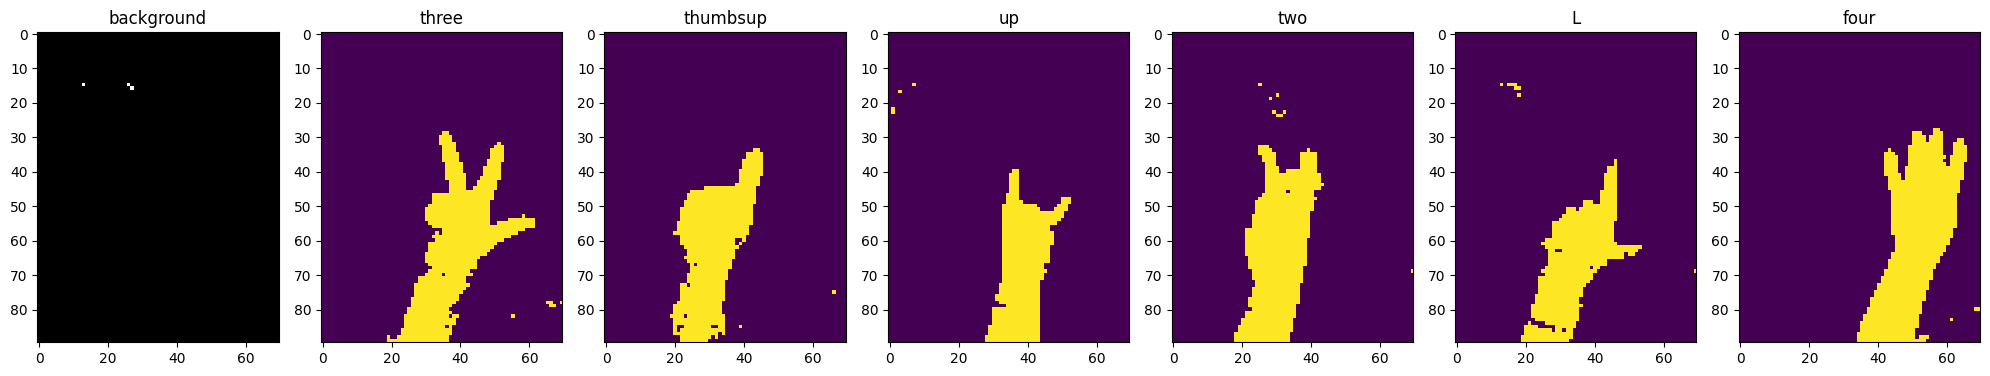

In [31]:
fig,ax = plt.subplots(1, len(categories), figsize=(20, 5))
for i, category in enumerate(categories):
    ax[i].imshow(Image.open(str(list(data_dir.glob(category + "/*.png"))[0])))
    ax[i].set_title(category)
fig.tight_layout()

Define some parameters for the loader:

In [41]:
batch_size = 32
img_height = 90#1024
img_width = 70#1024

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [42]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode="grayscale",
)

Found 10341 files belonging to 7 classes.
Using 8273 files for training.


In [43]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode="grayscale"
)

Found 10341 files belonging to 7 classes.
Using 2068 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [44]:
class_names = train_ds.class_names
print(class_names)

['L', 'background', 'four', 'three', 'thumbsup', 'two', 'up']


## Visualize the data

Here are the first nine images from the training dataset:

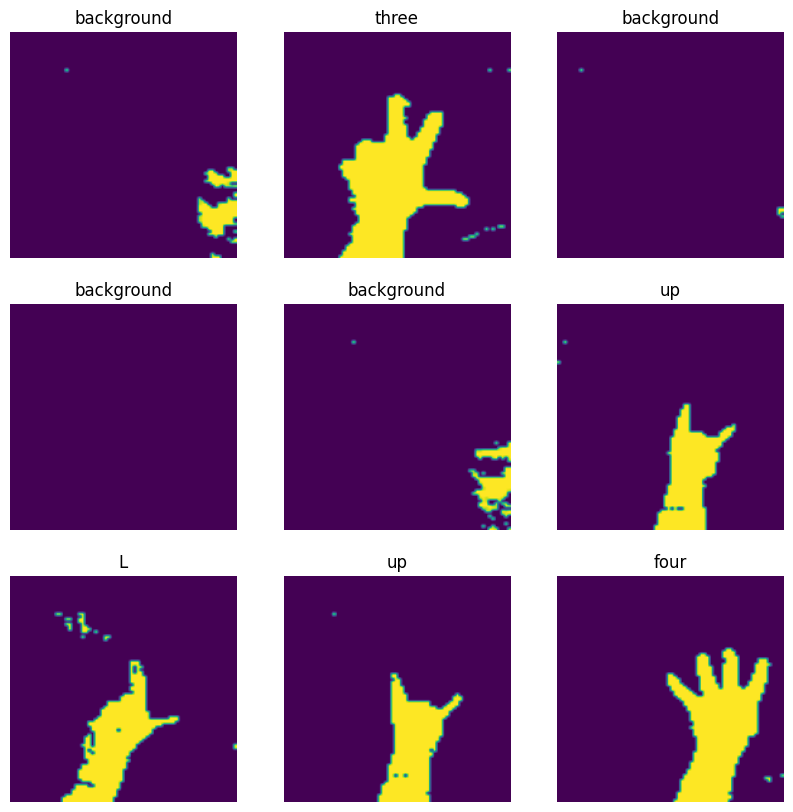

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

In [45]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [46]:
normalization_layer = layers.Rescaling(1./255)

In [47]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [48]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [49]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 90, 70, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 90, 70, 16)        32        
                                                                 
 max_pooling2d (MaxPooling2  (None, 45, 35, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 35, 32)        544       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 17, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 17, 64)        2

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [51]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


259/259 [==============================] - 11s 37ms/step - loss: 0.1400 - accuracy: 0.9613 - val_loss: 0.0262 - val_accuracy: 0.9932
Epoch 2/10
259/259 [==============================] - 10s 37ms/step - loss: 0.0264 - accuracy: 0.9923 - val_loss: 0.0487 - val_accuracy: 0.9831
Epoch 3/10
259/259 [==============================] - 10s 39ms/step - loss: 0.0174 - accuracy: 0.9942 - val_loss: 0.0138 - val_accuracy: 0.9966
Epoch 4/10
259/259 [==============================] - 10s 39ms/step - loss: 0.0162 - accuracy: 0.9944 - val_loss: 0.0158 - val_accuracy: 0.9942
Epoch 5/10
259/259 [==============================] - 10s 39ms/step - loss: 0.0050 - accuracy: 0.9983 - val_loss: 0.0134 - val_accuracy: 0.9952
Epoch 6/10
259/259 [==============================] - 22s 87ms/step - loss: 0.0071 - accuracy: 0.9982 - val_loss: 0.0142 - val_accuracy: 0.9966
Epoch 7/10
259/259 [==============================] - 10s 39ms/step - loss: 0.0020 - accuracy: 0.9992 - val_loss: 0.0086 - val_accuracy: 0.9981
Epo

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

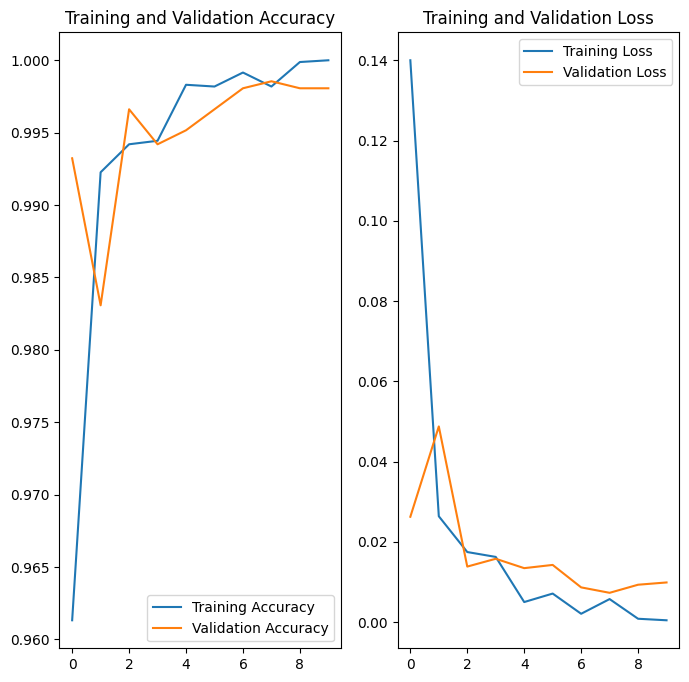

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
# predict and see how it performs
# add data augmentation

In [54]:
test_loss, test_acc = model.evaluate(val_ds, verbose = 2)
print('\nTest accuracy:', test_acc)

65/65 - 1s - loss: 0.0099 - accuracy: 0.9981 - 604ms/epoch - 9ms/step

Test accuracy: 0.9980657696723938


In [55]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(val_ds)

65/65 [==============================] - 1s 8ms/step


In [57]:
labels_flattened = []
predicted_flattened = []
images_flattened = []

for images, labels in val_ds:
    
    print(f"There are %i imgs of Class1 in %i imgs" %(np.sum(labels), len(labels)))
    
    for image, label in zip(images, labels):
        
        image_batched = tf.expand_dims(image, 0) # Create a batch
        predicted_temp = model.predict(image_batched)
        score = tf.nn.softmax(predicted_temp[0])
        
        images_flattened.append(image)
        predicted_flattened.append(class_names[np.argmax(score)])
        labels_flattened.append(class_names[label.numpy()])
    

There are 116 imgs of Class1 in 32 imgs
1/1 [==============================] - 0s 18ms/step
There are 102 imgs of Class1 in 32 imgs
1/1 [==============================] - 0s 18ms/step
There are 108 imgs of Class1 in 32 imgs
1/1 [==============================] - 0s 17ms/step
There are 93 imgs of Class1 in 32 imgs
1/1 [==============================] - 0s 17ms/step
There are 115 imgs of Class1 in 32 imgs
1/1 [==============================] - 0s 17ms/step
There are 106 imgs of Class1 in 32 imgs
1/1 [==============================] - 0s 18ms/step
There are 96 imgs of Class1 in 32 imgs
1/1 [==============================] - 0s 18ms/step
There are 93 imgs of Class1 in 32 imgs
1/1 [==============================] - 0s 18ms/step
There are 110 imgs of Class1 in 32 imgs
1/1 [==============================] - 0s 21ms/step
There are 87 imgs of Class1 in 32 imgs
1/1 [==============================] - 0s 19ms/step
There are 86 imgs of Class1 in 32 imgs
1/1 [==============================] - 0s 19m

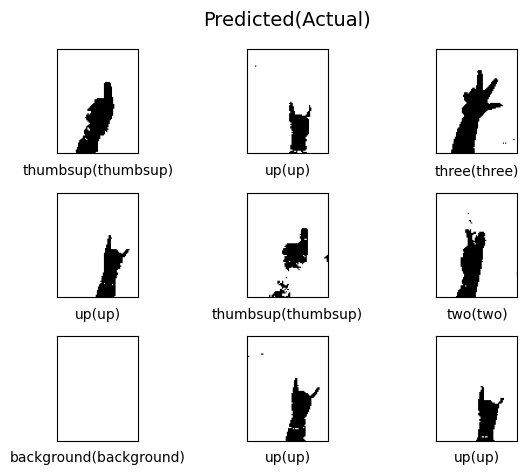

In [66]:
fig, axs = plt.subplots(3,3)

k = 0
for i in range(3):
    for j in range(3):
    
        k+=1
        ax = axs[i,j]
        ax.imshow(images_flattened[k], cmap = plt.cm.binary)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(predicted_flattened[k].replace("Category", "Cat") + "(" + labels_flattened[k].replace("Category", "Cat") + ")", fontsize = 10)

#set title
plt.suptitle("Predicted(Actual)", fontsize = 14)
#set tight layout
plt.tight_layout()
os.makedirs("output", exist_ok=True)
plt.savefig("output/predictions_sample.png")
        

In [67]:
#save model

model.save("output/model.h5")

/Users/krishna/Documents/projects/hand_gesture/hand_gesture_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
